In [1]:
import os
import json
import pandas as pd

import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [2]:
file_path = "turl_test_2k_prompts_50.jsonl"
device = torch.device("mps")

model_name = "osunlp/TableLlama"
config = transformers.AutoConfig.from_pretrained(model_name)
orig_ctx_len = getattr(config, "max_position_embeddings", None)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=orig_ctx_len, padding_side="left", use_fast=False)

In [3]:
# prompt formatting

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

In [4]:
!ls -larth "/Volumes/ssd/uncertainty/tablellama su 1800 prompts/"

total 37203968
drwx------  1 bono  staff   1.0M Feb 17 08:52 ..
-rwx------@ 1 bono  staff   4.4G Mar  7 12:23 TableLlama.1548780410.pickle
drwx------  1 bono  staff   1.0M Mar  7 14:45 .
-rwx------  1 bono  staff   4.0K Mar  7 14:46 ._TableLlama.1548780410.pickle
-rwx------@ 1 bono  staff   4.4G Mar  8 14:55 TableLlama.2573653229.pickle
-rwx------  1 bono  staff   4.0K Mar  8 14:56 ._TableLlama.2573653229.pickle
-rwx------@ 1 bono  staff   4.4G Mar  9 10:21 TableLlama.1765523202.pickle
-rwx------  1 bono  staff   4.0K Mar  9 10:27 ._TableLlama.1765523202.pickle
-rwx------@ 1 bono  staff   4.4G Mar 10 08:18 TableLlama.940523022.pickle
-rwx------  1 bono  staff   4.0K Mar 10 08:35 ._TableLlama.940523022.pickle


In [7]:
%%time

# load processed data

import os
import pickle

prefix = '/Volumes/ssd/uncertainty/tablellama su 1800 prompts/'

run = 0

outlist = []
for file in os.listdir(prefix):
    if file.endswith('pickle') and not file.startswith('.'):
        print(file)
        with open(os.path.join(prefix, file), 'rb') as handle:
            outlist_ = pickle.load(handle)
           
            for pid, o in enumerate(outlist_):
                del o['pre_output_proba_topn']
                del o['pre_output_proba_topk']
                del o['pre_output_true_entropies']
                del o['post_output_proba_topn']
                del o['post_output_proba_topk']
                del o['post_output_true_entropies']
                o['run'] = run
                o['pid'] = pid
                outlist.append(o)
        run += 1

len(outlist)

TableLlama.1548780410.pickle
TableLlama.1765523202.pickle
TableLlama.2573653229.pickle
TableLlama.940523022.pickle
CPU times: user 1min 58s, sys: 49.7 s, total: 2min 48s
Wall time: 2min 59s


7204

In [5]:
import pickle

if False:
    with open('1800.pickle', 'wb') as handle:
        pickle.dump(outlist, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('1800.pickle', 'rb') as handle:
        outlist = pickle.load(handle)

In [6]:
len(outlist)

7204

### check outputs against ground truth

In [7]:
%%time

# show results

c=0
t=0
h=0

truth = []

for idx, p in enumerate(outlist):
    print(idx, end='\r')
    c+=1
    # in
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    # computed
    # post_output_scores = p['post_output_scores']
    post_output_sequences = p['post_output_sequences']
    # bases
    baseid = len(inputs["input_ids"][0]) + 1
    endid = len(post_output_sequences[0])
    # lookout
    generated_ids = post_output_sequences
    generated_text = tokenizer.decode(generated_ids[0][baseid:endid], skip_special_tokens=True)
    # print
    # print(generated_text)
    # print(p['output'])
    # print('\n')
    #test
    a = generated_text.lower().strip()
    b = p['output'].lower().strip()
    # correct
    correct = False
    if (a in b) or (b in a) or (b.startswith(a)) or (a.startswith(b)): 
        correct = True
        t+=1
    # hallucinated
    elif a not in prompt.lower().strip(): 
        h+=1
    # incorrect
    else:
        pass
        #print(generated_text)
        #print(p['output'])
        #print('\n')
        # print(prompt)
        # print('\n')
        
    truth.append((p['run'], p['pid'], correct))

Token indices sequence length is longer than the specified maximum sequence length for this model (4857 > 4096). Running this sequence through the model will result in indexing errors


CPU times: user 1min 8s, sys: 2.28 s, total: 1min 11s
Wall time: 1min 15s


In [8]:
truth = pd.DataFrame(truth, columns=['run', 'pid', 'correct'])

In [9]:
truth.groupby('pid').size().value_counts()

4    1801
Name: count, dtype: int64

<Axes: xlabel='correct', ylabel='Count'>

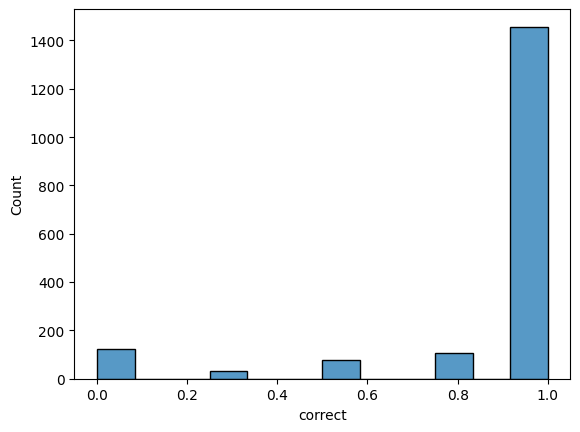

In [10]:
import seaborn as sns
sns.histplot(truth.groupby('pid').correct.mean())

In [11]:
accu = truth.groupby('pid').correct.mean()

In [12]:
accu[accu<1.].shape

(344,)

In [13]:
accu[accu<1.].value_counts()

correct
0.00    125
0.75    107
0.50     78
0.25     34
Name: count, dtype: int64

In [14]:
# all prompts with errors plus a sample of noerrors
err_idx = accu[accu<1.].index.tolist()
noerr_idx = accu[accu==1.].sample(len(accu[accu<1.]), random_state=42).index.tolist()

In [15]:
set(err_idx) & set(noerr_idx)

set()

In [16]:
selected_pids = set(err_idx) | set(noerr_idx)
len(selected_pids)

688

In [17]:
%%time

# load processed data

import os
import pickle

prefix = '/Volumes/ssd/uncertainty/tablellama su 1800 prompts/'

run = 0

outlist = []
for file in os.listdir(prefix):
    if file.endswith('pickle') and not file.startswith('.'):
        print(file)
        with open(os.path.join(prefix, file), 'rb') as handle:
            outlist_ = pickle.load(handle)
           
            for pid, o in enumerate(outlist_):
                if pid in selected_pids:
                    o['run'] = run
                    o['pid'] = pid
                    outlist.append(o)
        run += 1

len(outlist)

TableLlama.1548780410.pickle
TableLlama.1765523202.pickle
TableLlama.2573653229.pickle
TableLlama.940523022.pickle
CPU times: user 2min 20s, sys: 2min 3s, total: 4min 23s
Wall time: 5min 10s


2752

In [60]:
outlist[0].keys()

dict_keys(['table', 'cell', 'instruction', 'input', 'question', 'output', 'pre_output_proba_topn', 'pre_output_proba_topk', 'pre_output_true_entropies', 'post_output_sequences', 'post_output_proba_topn', 'post_output_proba_topk', 'post_output_true_entropies', 'elapsed', 'run', 'pid'])

In [18]:
outlist[-1]['run']

3

In [19]:
import pickle
with open('644.data.pickle', 'wb') as handle:
    pickle.dump(outlist, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [56]:
!ls -larth

total 43159720
-rw-r--r--@  1 bono  staff    15M May 14  2024 turl_test_2k_prompts_50.jsonl
-rw-r--r--   1 bono  staff    17B Feb 10 10:37 README.md
-rwx------@  1 bono  staff   4.8K Feb 19 14:05 runner.py
-rw-r--r--   1 bono  staff   137M Feb 19 16:32 gemma-2-2b-it.3892595837.pickle
-rw-r--r--@  1 bono  staff   5.0K Feb 20 09:23 prompt100.py
-rw-r--r--   1 bono  staff    16M Feb 20 20:07 tablellama.preprocessed.pickle
-rw-r--r--@  1 bono  staff   5.2K Feb 20 21:04 prompt100tablellama.py
-rw-r--r--   1 bono  staff   117M Feb 22 09:11 gemma-2-9b-it-4bit.3246737286.pickle
drwxr-xr-x   4 bono  staff   128B Feb 27 07:56 mirror
drwxr-xr-x@ 11 bono  staff   352B Feb 27 08:19 ..
-rw-r--r--@  1 bono  staff   5.3K Mar  2 14:55 prompt100gemmalocal.py
-rw-r--r--   1 bono  staff   222K Mar  4 13:37 jensension.ipynb
drwxr-xr-x   4 bono  staff   128B Mar  5 20:03 older tablellama
drwxr-xr-x  12 bono  staff   384B Mar  6 15:38 tablellama10runs
-rw-r--r--   1 bono  staff   450K Mar  6 16:03 tablellama

### DELETE ME

In [1]:
import pickle
with open('./644sample/644.data.pickle', 'rb') as handle:
    selected = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: './644sample/644.data.pickle'

In [5]:
len(selected)

2752

In [8]:
688*4

2752

In [9]:
%%time
selected_pids = set([s['pid'] for s in selected])

CPU times: user 3.22 ms, sys: 1.83 ms, total: 5.05 ms
Wall time: 5.1 ms


In [14]:
import pickle
with open('selected_pids.688.pickle', 'wb') as handle:
    pickle.dump(selected_pids, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
!ls -larth

total 3810400
-rw-r--r--@  1 bono  staff    15M May 14  2024 turl_test_2k_prompts_50.jsonl
-rw-r--r--   1 bono  staff    17B Feb 10 10:37 README.md
-rwx------@  1 bono  staff   4.8K Feb 19 14:05 runner.py
-rw-r--r--   1 bono  staff   137M Feb 19 16:32 gemma-2-2b-it.3892595837.pickle
-rw-r--r--@  1 bono  staff   5.0K Feb 20 09:23 prompt100.py
-rw-r--r--   1 bono  staff    16M Feb 20 20:07 tablellama.preprocessed.pickle
-rw-r--r--@  1 bono  staff   5.2K Feb 20 21:04 prompt100tablellama.py
-rw-r--r--   1 bono  staff   117M Feb 22 09:11 gemma-2-9b-it-4bit.3246737286.pickle
drwxr-xr-x   4 bono  staff   128B Feb 27 07:56 mirror
drwxr-xr-x@ 11 bono  staff   352B Feb 27 08:19 ..
-rw-r--r--@  1 bono  staff   5.3K Mar  2 14:55 prompt100gemmalocal.py
-rw-r--r--   1 bono  staff   222K Mar  4 13:37 jensension.ipynb
drwxr-xr-x   4 bono  staff   128B Mar  5 20:03 older tablellama
drwxr-xr-x  12 bono  staff   384B Mar  6 15:38 tablellama10runs
-rw-r--r--   1 bono  staff   450K Mar  6 16:03 tablellama-

### debug (transition scores)

In [10]:
# https://github.com/huggingface/transformers/issues/24841

1

In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import os
import time

# run params
temperature=1.0
top_p=0.9
max_new_tokens=64
use_cache=True
device = "mps"

model_name = "osunlp/TableLlama"

# load inputs
file_path = "turl_test_2k_prompts_50.jsonl"
device = torch.device(device)

with open(file_path, "r", encoding="utf-8") as f:
    prompts = [json.loads(line) for line in f]

config = transformers.AutoConfig.from_pretrained(model_name)
orig_ctx_len = getattr(config, "max_position_embeddings", None)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16).to(device)
model.resize_token_embeddings(32001)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=orig_ctx_len, padding_side="left", use_fast=False)
model.eval()

# build prompts
PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
# p = prompts[742] # 742 is shortest
p = prompts[840] # average joe

In [6]:
%%time

import copy
import torch
from transformers import StaticCache

# Initialize prompt cache
prompt_cache = StaticCache(config=model.config, max_batch_size=1, max_cache_len=2**14, device='mps', dtype=torch.float16)

# Generate initial prompt input
prompt = generate_prompt(p["instruction"], p["question"], p["input"])
inputs = tokenizer(prompt, return_tensors="pt").to(device)
prompt_ = prompt[:-1]
inputs_ = tokenizer(prompt_, return_tensors="pt").to(device)

CPU times: user 16.6 ms, sys: 920 ms, total: 937 ms
Wall time: 1.05 s


In [4]:
%%time
# as it were in the script
with torch.no_grad():
    pre_output = model(**inputs, use_cache=True)

CPU times: user 201 ms, sys: 614 ms, total: 815 ms
Wall time: 2.58 s


In [5]:
%%time
# as it were in the script

post_output = model.generate(
    **inputs,
    max_new_tokens=max_new_tokens,
    temperature=temperature,
    top_p=top_p,
    output_scores=True,
    return_dict_in_generate=True,
    output_logits=True,
    use_cache=True
)

From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


CPU times: user 1.81 s, sys: 1.15 s, total: 2.95 s
Wall time: 5.82 s


In [6]:
%%time 
# No cache
post_output = model.generate(
    **inputs,
    max_new_tokens=max_new_tokens,
    temperature=temperature,
    top_p=top_p,
    output_scores=True,
    return_dict_in_generate=True,
    output_logits=True,
    use_cache=False 
)

CPU times: user 4.3 s, sys: 6.45 s, total: 10.7 s
Wall time: 1min


In [31]:
2**12

4096

In [8]:
%%time

prompt_cache = StaticCache(config=model.config, max_batch_size=1, 
                           max_cache_len = 2**12, 
                           device='mps', dtype=torch.bfloat16)

# Generate cache
with torch.no_grad():
    pre_output = model(**inputs_, past_key_values=prompt_cache, use_cache=False)
    prompt_cache = pre_output.past_key_values

CPU times: user 128 ms, sys: 656 ms, total: 784 ms
Wall time: 4.55 s


In [11]:
%%time 
# With cache
post_output = model.generate(
    **inputs,
    max_new_tokens=max_new_tokens,
    temperature=temperature,
    top_p=top_p,
    output_scores=True,
    return_dict_in_generate=True,
    output_logits=True,
    past_key_values=copy.deepcopy(prompt_cache),
    use_cache=True 
)

CPU times: user 1.32 s, sys: 905 ms, total: 2.23 s
Wall time: 6.64 s


In [10]:
%%time 
# With cache
post_output = model.generate(
    **inputs,
    max_new_tokens=max_new_tokens,
    temperature=temperature,
    top_p=top_p,
    output_scores=True,
    return_dict_in_generate=True,
    output_logits=True,
    past_key_values=copy.deepcopy(prompt_cache),
    use_cache=False 
)

CPU times: user 3.39 s, sys: 5.9 s, total: 9.3 s
Wall time: 1min 32s


In [12]:
%%time 
# Reset cache

prompt_cache = StaticCache(config=model.config, max_batch_size=1, 
                           max_cache_len = 2**12, 
                           device='mps', dtype=torch.bfloat16)

post_output = model.generate(
    **inputs,
    max_new_tokens=max_new_tokens,
    temperature=temperature,
    top_p=top_p,
    output_scores=True,
    return_dict_in_generate=True,
    output_logits=True,
    past_key_values=copy.deepcopy(prompt_cache),
    use_cache=True 
)

CPU times: user 1.45 s, sys: 1.54 s, total: 2.99 s
Wall time: 10.1 s


In [8]:
%%time 
# With cache
post_output = model.generate(
    **inputs,
    max_new_tokens=max_new_tokens,
    temperature=temperature,
    top_p=top_p,
    output_scores=True,
    return_dict_in_generate=True,
    output_logits=True,
    past_key_values=copy.deepcopy(prompt_cache),
    use_cache=True 
)

CPU times: user 1.41 s, sys: 7.7 s, total: 9.11 s
Wall time: 24.1 s


In [4]:
%%time

prompt = generate_prompt(p["instruction"], p["question"], p["input"])
inputs = tokenizer(prompt, return_tensors="pt").to(device)
with torch.no_grad():
    pre_output = model(**inputs, use_cache=use_cache)
pre_output = pre_output.logits.cpu().detach()

CPU times: user 308 ms, sys: 650 ms, total: 958 ms
Wall time: 5.64 s


In [5]:
inputs.input_ids.shape

torch.Size([1, 1073])

In [6]:
2**14

16384

In [10]:
prompt[-1]

':'

In [18]:
%%time
import copy
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, DynamicCache, StaticCache
from accelerate.test_utils.testing import get_backend

prompt_cache = StaticCache(config=model.config, max_batch_size=1, max_cache_len=2**14, device='mps', dtype=torch.float16)

prompt = generate_prompt(p["instruction"], p["question"], p["input"])
prompt_ = prompt[:-1]

inputs = tokenizer(prompt_, return_tensors="pt").to(device)

with torch.no_grad():
    pre_output = model(**inputs, past_key_values = prompt_cache)
    prompt_cache = pre_output.past_key_values

CPU times: user 199 ms, sys: 1.16 s, total: 1.36 s
Wall time: 9.59 s


In [19]:
%%time
new_inputs = tokenizer(prompt, return_tensors="pt").to('mps')
outputs = model.generate(**new_inputs, past_key_values=prompt_cache, max_new_tokens=1)

CPU times: user 98.4 ms, sys: 367 ms, total: 466 ms
Wall time: 3.77 s


RuntimeError: MPS backend out of memory (MPS allocated: 81.38 GB, other allocations: 1.84 MB, max allowed: 81.60 GB). Tried to allocate 512.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [40]:
2**16

65536

CPU times: user 1.65 s, sys: 6.02 s, total: 7.67 s
Wall time: 29.3 s


In [3]:
outputs

In [27]:
generated

tensor([[    1, 13866,   338,  ..., 29937, 13291, 29901]])

In [28]:
    num_tokens=20
    
    outputs = model(**inputs, use_cache=True, return_dict=True)
    past = outputs.past_key_values

    generated = input_ids.to(device)

We detected that you are passing `past_key_values` as a tuple of tuples. This is deprecated and will be removed in v4.47. Please convert your cache or use an appropriate `Cache` class (https://huggingface.co/docs/transformers/kv_cache#legacy-cache-format)


In [31]:
    for k in range(5):
        print(k)
        for _ in range(num_tokens):
            # For each new step, only pass the last token along with the cache
            next_input = generated[:, -1:]
            outputs = model(next_input, past_key_values=past, use_cache=True, return_dict=True)
            logits = outputs.logits
            past = outputs.past_key_values  # Update the cache with new key/value pairs

            # Greedily select the next token (alternatively, you can sample)
            next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
            generated = torch.cat((generated, next_token), dim=-1)

        # Decode the full sequence of tokens into text
        pippo = tokenizer.decode(generated[0], skip_special_tokens=True)

0


RuntimeError: MPS backend out of memory (MPS allocated: 81.61 GB, other allocations: 3.81 MB, max allowed: 81.60 GB). Tried to allocate 8.64 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [20]:
past_key_values = copy.deepcopy(prompt_cache)

In [23]:
dir(past_key_values)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_se

In [21]:
# new_inputs = tokenizer(prompt + " fottiti", return_tensors="pt").to('mps')
outputs = model.generate(**inputs, past_key_values=past_key_values, max_new_tokens=64)

IndexError: index -1 is out of bounds for dimension 0 with size 0

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

def generate_text_with_cache(model, tokenizer, prompt, num_tokens=20):
    
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    outputs = model(input_ids, use_cache=True, return_dict=True)
    past = outputs.past_key_values  # Cache of previous key/value pairs

    generated = input_ids

    # Generate tokens one by one using the cached past
    for _ in range(num_tokens):
        # For each new step, only pass the last token along with the cache
        next_input = generated[:, -1:]
        outputs = model(next_input, past_key_values=past, use_cache=True, return_dict=True)
        logits = outputs.logits
        past = outputs.past_key_values  # Update the cache with new key/value pairs

        # Greedily select the next token (alternatively, you can sample)
        next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
        generated = torch.cat((generated, next_token), dim=-1)

    # Decode the full sequence of tokens into text
    return tokenizer.decode(generated[0], skip_special_tokens=True)

if __name__ == "__main__":
    # Specify the model you want to use; for example, GPT-2
    model_name = "gpt2"  # Change this to your desired model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    
    prompt = "Hello, how are you?"
    print("Prompt:", prompt)
    
    # Generate text by extending the prompt with additional tokens
    output_text = generate_text_with_cache(model, tokenizer, prompt, num_tokens=20)
    print("\nGenerated text:")
    print(output_text)


In [ ]:
import copy
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, DynamicCache, StaticCache
from accelerate.test_utils.testing import get_backend

DEVICE, _, _ = get_backend() # automatically detects the underlying device type (CUDA, CPU, XPU, MPS, etc.)
model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16, device_map=DEVICE)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Init StaticCache with big enough max-length (1024 tokens for the below example)
# You can also init a DynamicCache, if that suits you better
prompt_cache = StaticCache(config=model.config, max_batch_size=1, max_cache_len=1024, device=DEVICE, dtype=torch.bfloat16)

INITIAL_PROMPT = "You are a helpful assistant. "
inputs_initial_prompt = tokenizer(INITIAL_PROMPT, return_tensors="pt").to(DEVICE)
# This is the common prompt cached, we need to run forward without grad to be abel to copy
with torch.no_grad():
     prompt_cache = model(**inputs_initial_prompt, past_key_values = prompt_cache).past_key_values

prompts = ["Help me to write a blogpost about travelling.", "What is the capital of France?"]
responses = []
for prompt in prompts:
    new_inputs = tokenizer(INITIAL_PROMPT + prompt, return_tensors="pt").to(DEVICE)
    past_key_values = copy.deepcopy(prompt_cache)
    outputs = model.generate(**new_inputs, past_key_values=past_key_values,max_new_tokens=20)
    response = tokenizer.batch_decode(outputs)[0]
    responses.append(response)

print(responses)

In [6]:
%%time

post_output = model.generate(
    **inputs,
    max_new_tokens=max_new_tokens,
    temperature=temperature,
    top_p=top_p,
    output_scores=True,
    return_dict_in_generate=True,
    output_logits=True,
    use_cache=use_cache
    )

From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


CPU times: user 1.87 s, sys: 945 ms, total: 2.82 s
Wall time: 5.5 s


In [7]:
transition_scores = model.compute_transition_scores(post_output.sequences, post_output.scores, normalize_logits=True)

In [8]:
post_output.sequences.shape, len(post_output.scores), post_output.scores[0].shape, transition_scores.shape

(torch.Size([1, 1094]), 21, torch.Size([1, 32001]), torch.Size([1, 21]))

In [9]:
post_output.scores[0].shape

torch.Size([1, 32001])

In [10]:
transition_scores[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='mps:0')

In [11]:
log_likelihoods = [score.item() for score in transition_scores[0]]

In [13]:
log_likelihoods

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [14]:
transition_scores_s = model.compute_transition_scores(post_output.sequences, post_output.scores, normalize_logits=True)
log_likelihoods_s = [score.item() for score in transition_scores[0]]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [15]:
transition_scores

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='mps:0')

In [16]:
transition_scores_l = model.compute_transition_scores(post_output.sequences, post_output.logits, normalize_logits=True)
log_likelihoods_l = [score.item() for score in transition_scores[0]]

[-4.768370445162873e-07,
 -0.09085541218519211,
 -0.10185058414936066,
 -4.768370445162873e-07,
 -1.1920928244535389e-07,
 -2.407998726994265e-05,
 -0.0023836076725274324,
 0.0,
 0.0,
 -0.022649873048067093,
 -0.007525428663939238,
 -9.536738616588991e-07,
 -3.576278118089249e-07,
 0.0,
 -2.3841855067985307e-07,
 0.0,
 -3.2186455882765586e-06,
 -7.867782187531702e-06,
 -5.960462772236497e-07,
 -1.1920928244535389e-07,
 0.0]

In [17]:
transition_scores

tensor([[-4.7684e-07, -9.0855e-02, -1.0185e-01, -4.7684e-07, -1.1921e-07,
         -2.4080e-05, -2.3836e-03,  0.0000e+00,  0.0000e+00, -2.2650e-02,
         -7.5254e-03, -9.5367e-07, -3.5763e-07,  0.0000e+00, -2.3842e-07,
          0.0000e+00, -3.2186e-06, -7.8678e-06, -5.9605e-07, -1.1921e-07,
          0.0000e+00]], device='mps:0')